In [17]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf

import warnings
warnings.filterwarnings('ignore')

In [3]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i+look_back, 0])
	return np.array(dataX), np.array(dataY)

def plot_history(history):
    mse = history.history['loss']
    val_mse = history.history['val_loss']
    x = range(1, len(mse) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, mse, 'b', label='Training MSE')
    plt.plot(x, val_mse, 'r', label='Validation MSE')
    plt.title('Training and validation LOSS - MSE')
    plt.xlabel('epoca')
    plt.ylabel('mse')
    plt.legend()
    
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-actual)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})    

In [7]:
df_temporal = pd.read_csv("base_ex4.csv");
df_temporal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   valor   389 non-null    int64
dtypes: int64(1)
memory usage: 3.2 KB


# Previsão por Dias

In [8]:
X = np.array(df_temporal.valor)
X = X.astype('float32').reshape(-1,1)

In [9]:
scaler = MinMaxScaler()
#scaler = StandardScaler()
X = scaler.fit_transform(X)

In [10]:
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size

train = X[0:train_size,:]
test =  X[train_size:len(X),:]

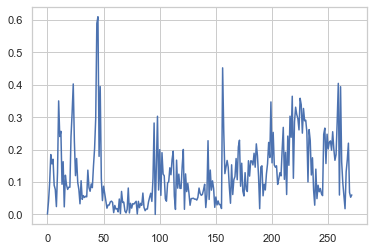

In [11]:
plt.plot(train)

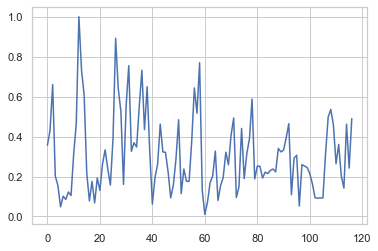

In [12]:
plt.plot(test)

In [29]:
best = 0
best_mse = np.Infinity
for n in range(51, 61, 1):
    look_back = n
    X_train, y_train = create_dataset(train, look_back)
    X_test, y_test = create_dataset(test, look_back)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    model = Sequential()
    model.add(LSTM(128, input_shape=(look_back, 1), dropout=0.2))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=1, verbose=0)
    mse = min(history.history['val_loss'])
    if best_mse > mse:
        best_mse = mse
        best = n
    print(f"look back {n} - {mse} | best {best} - {best_mse}")    

look back 51 - 0.023757873103022575 | best 51 - 0.023757873103022575
look back 52 - 0.024442579597234726 | best 51 - 0.023757873103022575
look back 53 - 0.025979317724704742 | best 51 - 0.023757873103022575
look back 54 - 0.02638334594666958 | best 51 - 0.023757873103022575
look back 55 - 0.025913167744874954 | best 51 - 0.023757873103022575
look back 56 - 0.025826003402471542 | best 51 - 0.023757873103022575
look back 57 - 0.023103348910808563 | best 57 - 0.023103348910808563
look back 58 - 0.02338988147675991 | best 57 - 0.023103348910808563
look back 59 - 0.01975730061531067 | best 59 - 0.01975730061531067
look back 60 - 0.02011708728969097 | best 59 - 0.01975730061531067


In [30]:
# quantidade de atrasos
look_back = 59

X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

In [31]:
# reshape da entrada para ser [amostras, time steps, caracteristicas]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Modelo LSTM

In [32]:
model = Sequential()
model.add(LSTM(128, input_shape=(look_back, 1), dropout=0.2))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [33]:
checkpointer = ModelCheckpoint(filepath='./modelo_lstm_ex4.hdf5', verbose=1, save_best_only=True, monitor='val_loss')

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=1, callbacks=[checkpointer])

Epoch 1/50
212/212 [==============================] - ETA: 0s - loss: 0.0069
Epoch 00001: val_loss improved from inf to 0.02246, saving model to .\modelo_lstm_ex4.hdf5
212/212 [==============================] - 2s 10ms/step - loss: 0.0069 - val_loss: 0.0225
Epoch 2/50
212/212 [==============================] - ETA: 0s - loss: 0.0061
Epoch 00002: val_loss did not improve from 0.02246
212/212 [==============================] - 2s 8ms/step - loss: 0.0061 - val_loss: 0.0285
Epoch 3/50
211/212 [============================>.] - ETA: 0s - loss: 0.0067
Epoch 00003: val_loss did not improve from 0.02246
212/212 [==============================] - 2s 8ms/step - loss: 0.0066 - val_loss: 0.0231
Epoch 4/50
211/212 [============================>.] - ETA: 0s - loss: 0.0073
Epoch 00004: val_loss improved from 0.02246 to 0.02171, saving model to .\modelo_lstm_ex4.hdf5
212/212 [==============================] - 2s 8ms/step - loss: 0.0073 - val_loss: 0.0217
Epoch 5/50
211/212 [===========================

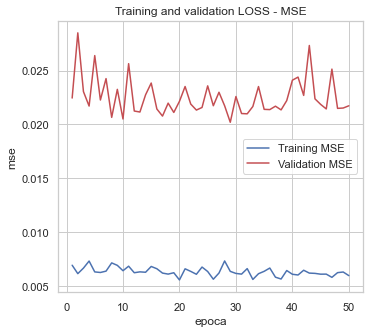

In [34]:
plot_history(history)

In [35]:
model = load_model("./modelo_lstm_ex4.hdf5")

In [36]:
# Predições
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [37]:
# Faz a transformação inversa das predições
trainPredict = scaler.inverse_transform(trainPredict)
y_tr = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_te = scaler.inverse_transform([y_test])

In [38]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(y_tr[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_te[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2250207.45 RMSE
Test Score: 4245731.37 RMSE


In [39]:
# Prepara o vetor para plotagem do conjunto de treinamento
trainPredictPlot = np.empty_like(X)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back-1:len(trainPredict)+look_back-1, :] = trainPredict

In [40]:
# Prepara o vetor para plotagem do conjunto das predições
testPredictPlot = np.empty_like(X)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(X)-2, :] = testPredict

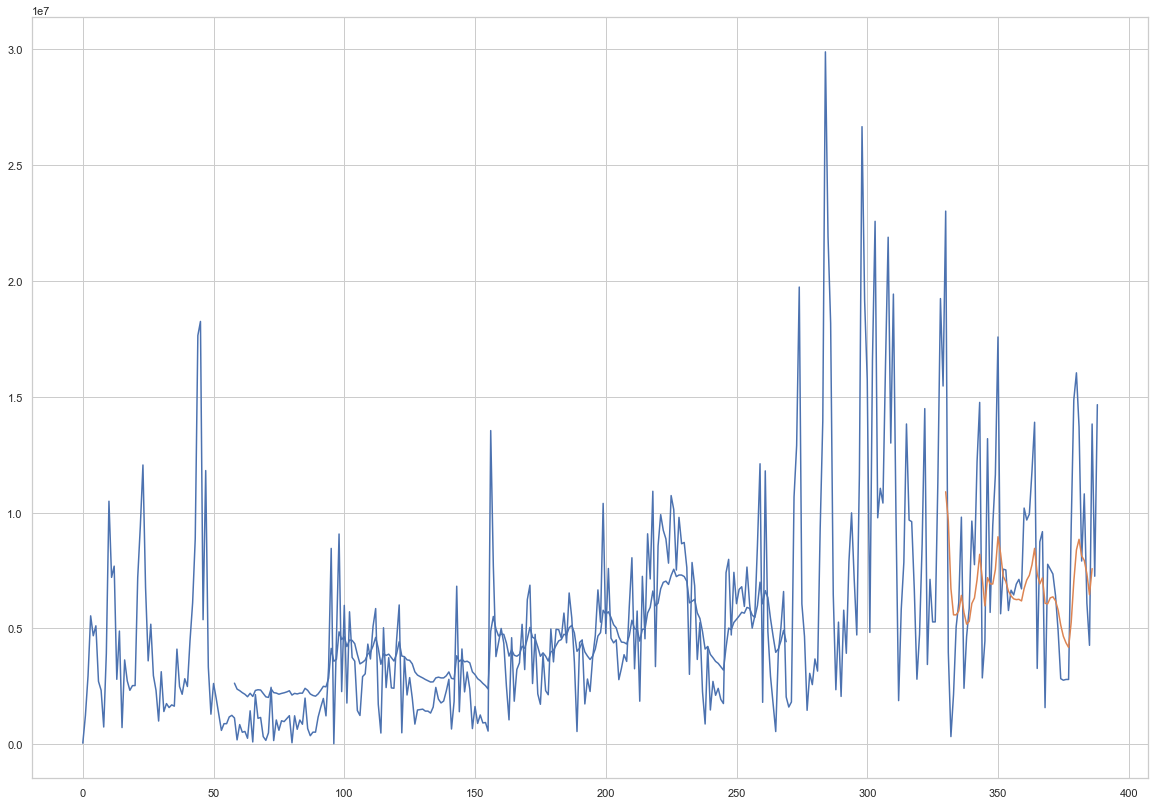

In [41]:
# Plota o dataset, as predições sobre o conjunto de treinamento e teste
plt.figure(figsize=(20,14))
plt.plot(scaler.inverse_transform(X), color='b')
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [42]:
y_te = y_te.reshape(-1,1)
mean_absolute_percentage_error(testPredict, y_te)

0.48641863568876004